In [1]:
# Set retina display
%config InlineBackend.figure_format = 'retina'

# X-ray Tomography

In [2]:
import numpy as np
def compute_ray_segment_length(xsrc, ysrc, xrcv, yrcv, xgrid, ygrid, debug=False):
    ''' 
    Compute segment lengths of a straight ray within crossing grid cells
    Params:
    - xsrc, ysrc: Source coordinates
    - xrcv, yrcv: Receiver coordinates
    - xgrid, ygrid: Grid cell boundaries
    Return:
    - dl_cell: Ray segment lengths in each grid cell
    '''
    ## Determine intersections of the ray to x-grids
    xfrac = (xgrid-xsrc) / (xrcv-xsrc)
    x1 = np.concatenate(([xsrc, xrcv], xgrid[(xfrac>0) & (xfrac<1)]))
    y1 = (yrcv-ysrc) / (xrcv-xsrc) * (x1 - xsrc) + ysrc

    ## Determine intersections of the ray to y-grids
    yfrac = (ygrid-ysrc) / (yrcv-ysrc)
    y2 = ygrid[(yfrac>0) & (yfrac<1)]
    x2 = (xrcv-xsrc) / (yrcv-ysrc) * (y2 - ysrc) + xsrc

    ## Sort intersections point by their distance from the source
    intersections = np.column_stack((np.concatenate((x1, x2)), np.concatenate((y1, y2))))
    dist_from_src = np.sqrt(np.sum((intersections-[xsrc, ysrc])**2, axis=1))
    sorted_intersections = intersections[np.argsort(dist_from_src)]
    segment_midpoints = (sorted_intersections[:-1] + sorted_intersections[1:]) / 2

    ## Assign ray lengths to grid cells
    dl_cell = np.zeros((len(xgrid)-1, len(ygrid)-1))
    ii = np.digitize(segment_midpoints[:, 0], xgrid) - 1
    jj = np.digitize(segment_midpoints[:, 1], ygrid) - 1
    dl_cell[ii, jj] = np.diff(np.sort(dist_from_src))

    if debug:
        return dl_cell, sorted_intersections
    else:
        return dl_cell.ravel()

def build_Jacobian(src_coords, rcv_coords, xgrid, ygrid):
    ''' 
    Build the Jacobian matrix for straight ray paths given source and receiver coordinates
    Params:
    - src_coords: Source coordinates (N, 2)
    - rcv_coords: Receiver coordinates (N, 2)
    - xgrid: X grid boundaries
    - ygrid: Y grid boundaries
    Return: 
    - Jacobian: Jacobian matrix (number of rays, number of cells)
    '''
    Jacobian = []
    for src, rcv in zip(src_coords, rcv_coords):
        Jacobian.append(compute_ray_segment_length(src[0], src[1], rcv[0], rcv[1], xgrid, ygrid))
    return np.array(Jacobian)

$$
d_i = \sum_{j=1}^N \frac{\delta l_{ij}}{v_i} = \sum_{j=1}^N = \delta l_{ij} s_i
$$

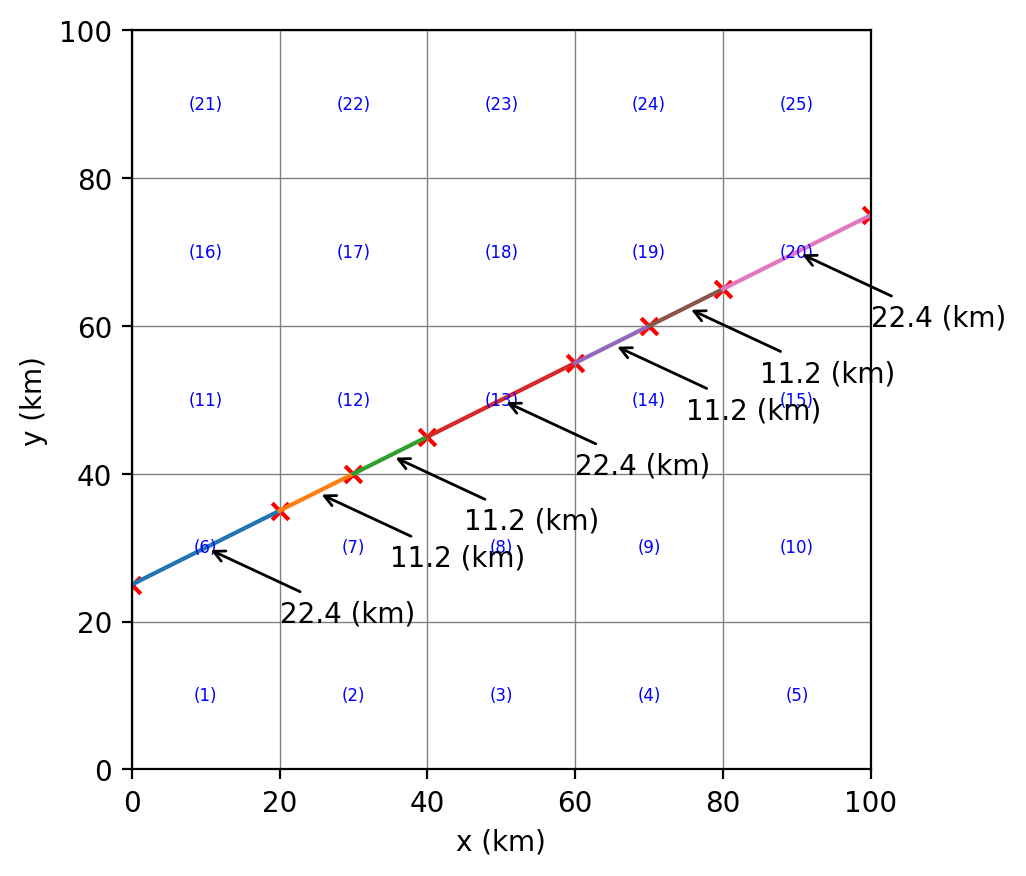

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Computation domain
xmin, xmax = 0, 100
xcenter = (xmin + xmax) / 2
ymin, ymax = 0, 100
ycenter = (ymin + ymax) / 2
## Grid cell definition
xgrid = np.linspace(xmin, xmax, 6)
ygrid = np.linspace(ymin, ymax, 6)
## Coordinate of grid cell centers
xmesh, ymesh = np.meshgrid((xgrid[:-1]+xgrid[1:])/2, (ygrid[:-1]+ygrid[1:])/2, indexing='ij')

dl_cell, sorted_intersections = compute_ray_segment_length(xsrc=xmin, ysrc=25, xrcv=xmax, yrcv=75, xgrid=xgrid, ygrid=ygrid, debug=True)

fig, ax = plt.subplots()

for x in xgrid:
    ax.vlines(x, ymin=ygrid.min(), ymax=ygrid.max(), color='gray', lw=0.5)
for y in ygrid:
    ax.hlines(y, xmin=xgrid.min(), xmax=xgrid.max(), color='gray', lw=0.5)

for i in range(xgrid.size-1):
    for j in range(ygrid.size-1):
        ax.text(xmesh[j, i], ymesh[j, i], f'({i*(xgrid.size-1) + j + 1})', color='blue', ha='center', va='center', fontsize=6)

for i in range(len(sorted_intersections)-1):
    seg = np.array([sorted_intersections[i], sorted_intersections[i+1]])
    ax.plot(seg[:, 0], seg[:, 1])
    x, y = (seg[0, 0]+seg[1, 0])/2, (seg[0, 1]+seg[1, 1])/2
    ax.annotate(f'{np.linalg.norm(seg[1]-seg[0]):.1f} (km)', xy=(x, y), xytext=(x+10, y-10), 
                arrowprops=dict(arrowstyle='->'))
ax.scatter(sorted_intersections[:, 0], sorted_intersections[:, 1], marker='x', color='r')

ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), xlabel='x (km)', ylabel='y (km)', aspect='equal')

plt.show()

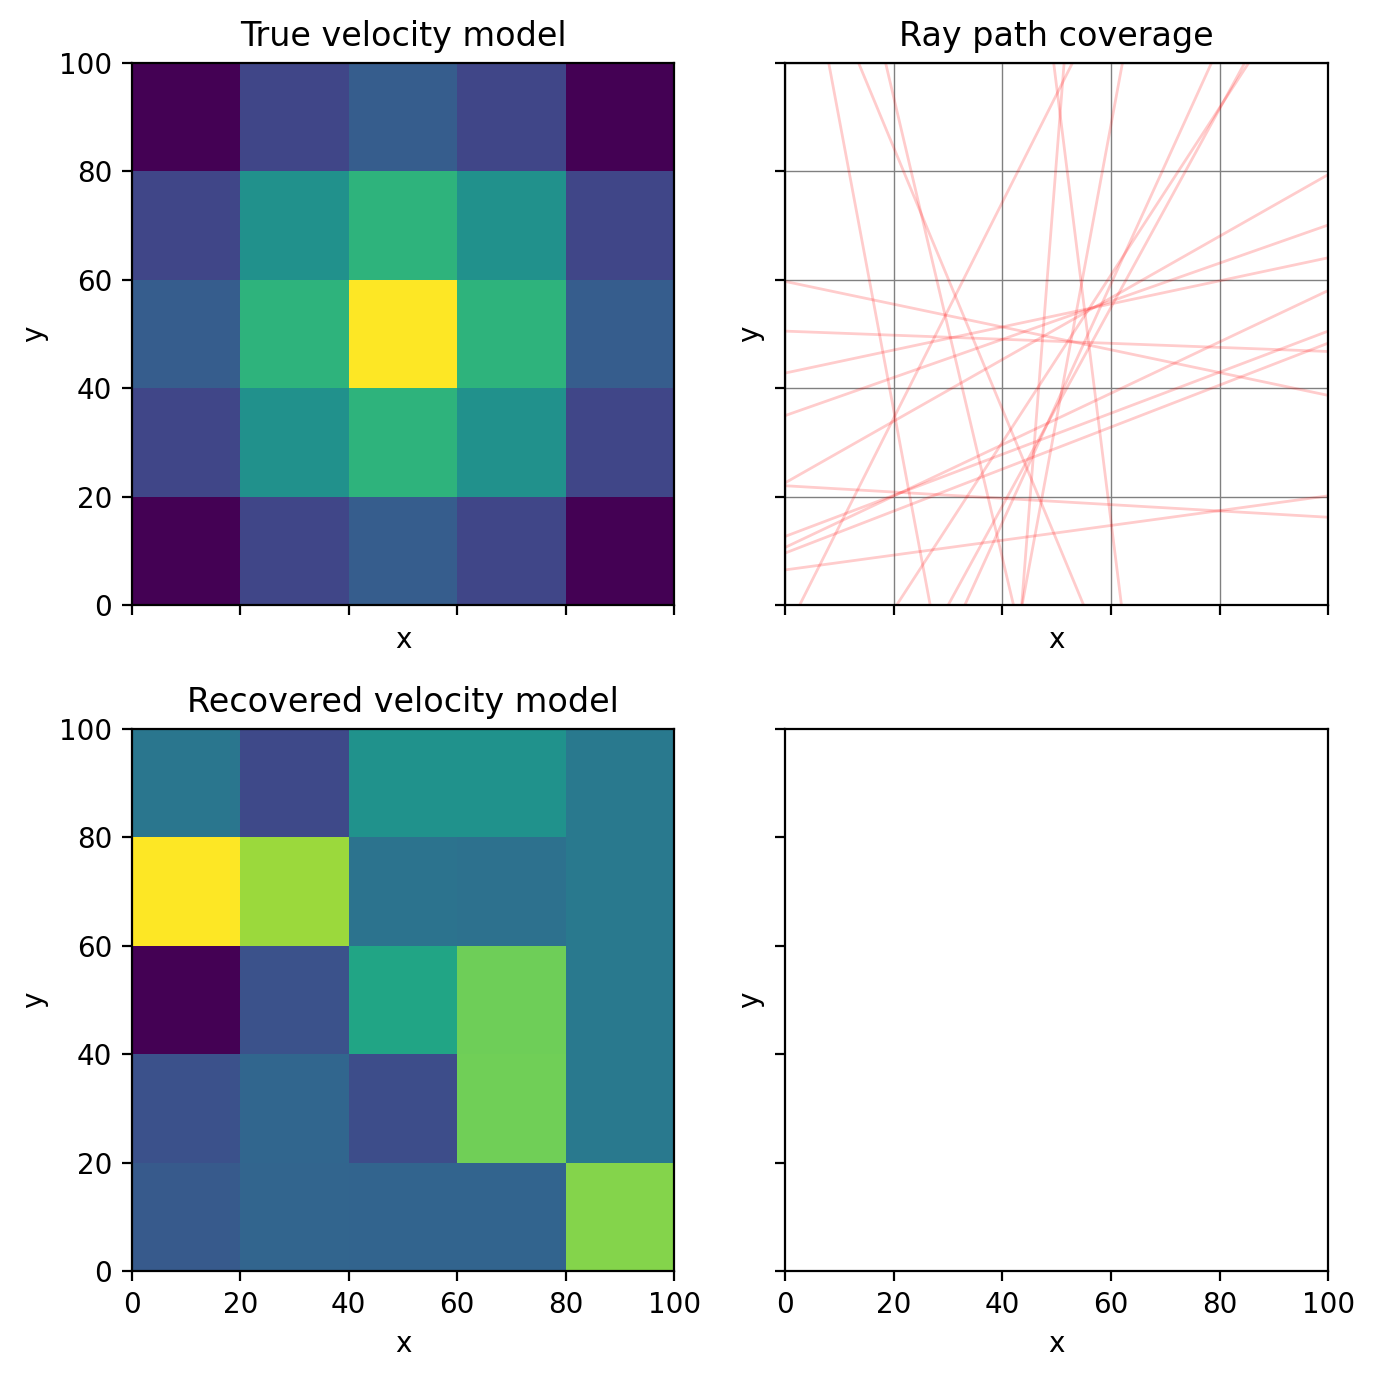

In [13]:
np.random.seed(2)

## Ray crossing to sample the region
nrays = 10
src_xy = np.column_stack((np.random.uniform(xmin, xmax, nrays), np.full(nrays, ymin)))
rcv_xy = np.column_stack((np.random.uniform(xmin, xmax, nrays), np.full(nrays, ymax)))
src_xy = np.vstack((src_xy, np.column_stack((np.full(nrays, xmin), np.random.uniform(ymin, ymax, nrays)))))
rcv_xy = np.vstack((rcv_xy, np.column_stack((np.full(nrays, xmax), np.random.uniform(ymin, ymax, nrays)))))

## Create design matrix
v0 = 2 # km/s
G = build_Jacobian(src_xy, rcv_xy, xgrid, ygrid) / v0 # Convert length to time

## True velocity perturbation model
d = np.sqrt((xmesh-xcenter)**2 + (ymesh-ycenter)**2)
dv_v = ((1 - d/d.max()) * 0.04)
dv_v -= np.mean(dv_v)

## Simulate travel residual travel times
m_true = dv_v.ravel()
dt = G @ m_true

## Least-square inversion
m_L2 = np.linalg.inv(G.T @ G) @ G.T @ dt
dv_v_inv = m_L2.reshape(xmesh.shape)

def plot_model(dv_v_true, dv_v_inv, title='', vmin=None, vmax=None):
    ## Plot problem setup
    fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)
    for _ in ax.flatten():
        _.set(aspect='equal', xlabel='x', ylabel='y', xlim=(xmin, xmax), ylim=(ymin, ymax))
    ## True input velocity model
    ax[0, 0].pcolormesh(xmesh, ymesh, dv_v_true, shading='auto', cmap='viridis', vmin=dv_v_true.min(), vmax=dv_v_true.max())
    ax[0, 0].set_title('True velocity model')
    ## Ray path coverage
    for y in ygrid:
        ax[0, 1].hlines(y, xmin=xgrid.min(), xmax=xgrid.max(), color='gray', lw=0.5)
    for x in xgrid:
        ax[0, 1].vlines(x, ymin=ygrid.min(), ymax=ygrid.max(), color='gray', lw=0.5)
    for src, rcv in zip(src_xy, rcv_xy):
        ax[0, 1].plot([src[0], rcv[0]], [src[1], rcv[1]], color='r', lw=1, alpha=.2)
    ax[0, 1].set_title('Ray path coverage')
    ## Recovered velocity model
    # ax[1, 0].pcolormesh(xmesh, ymesh, dv_v_inv, shading='auto', cmap='viridis', vmin=dv_v_true.min(), vmax=dv_v_true.max())
    ax[1, 0].pcolormesh(xmesh, ymesh, dv_v_inv, shading='auto', cmap='viridis', vmin=dv_v_inv.min(), vmax=dv_v_inv.max())
    ax[1, 0].set_title('Recovered velocity model')
    ## Difference model
    # ax[1, 1].pcolormesh(xmesh, ymesh, dv_v_inv - dv_v_true, shading='auto', cmap='gray', vmin=dv_v_true.min(), vmax=dv_v_true.min())
    # ax[1, 1].set_title('Model difference')
    fig.tight_layout()

plot_model(dv_v, dv_v_inv, title='Least-square inversion')
plt.show()

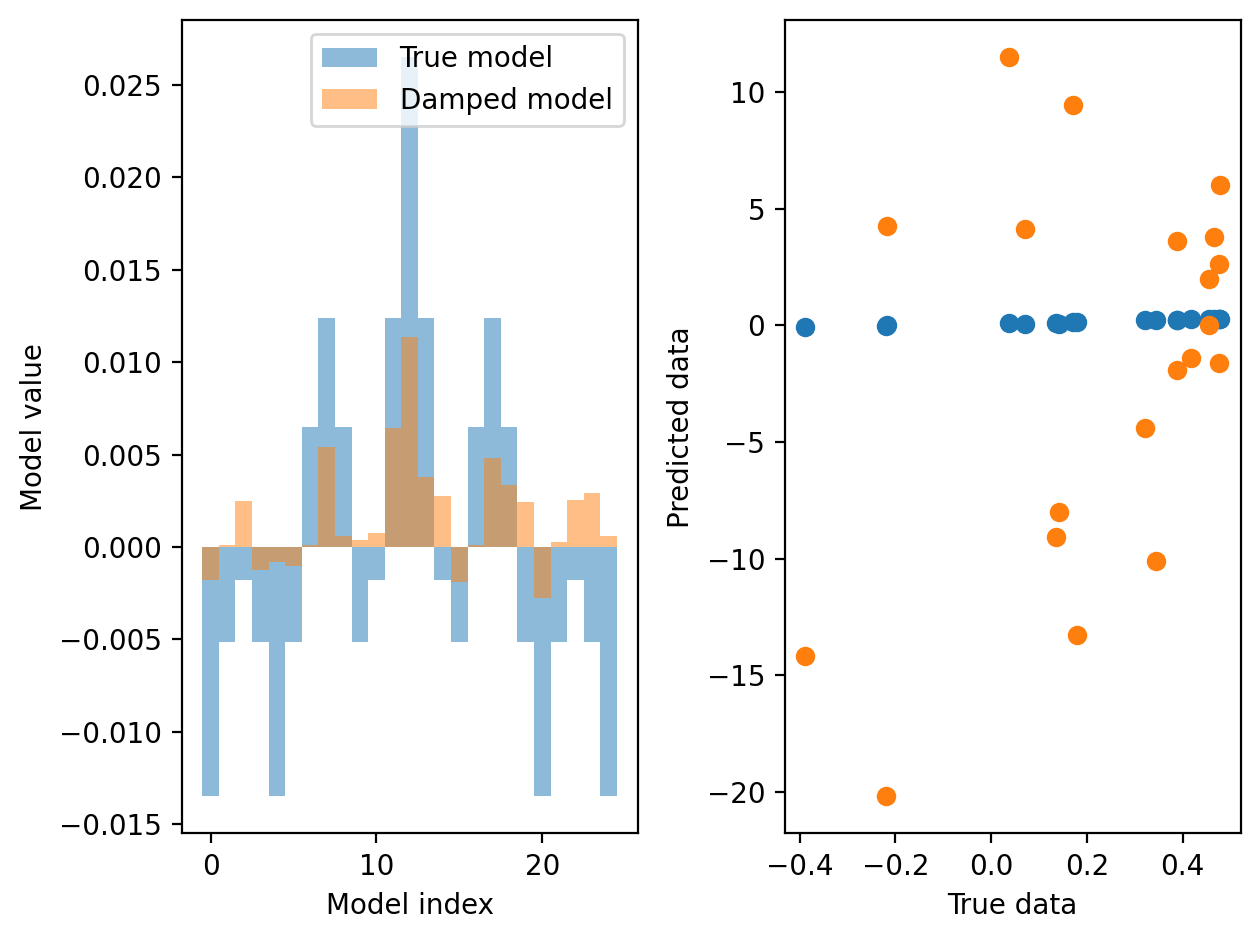

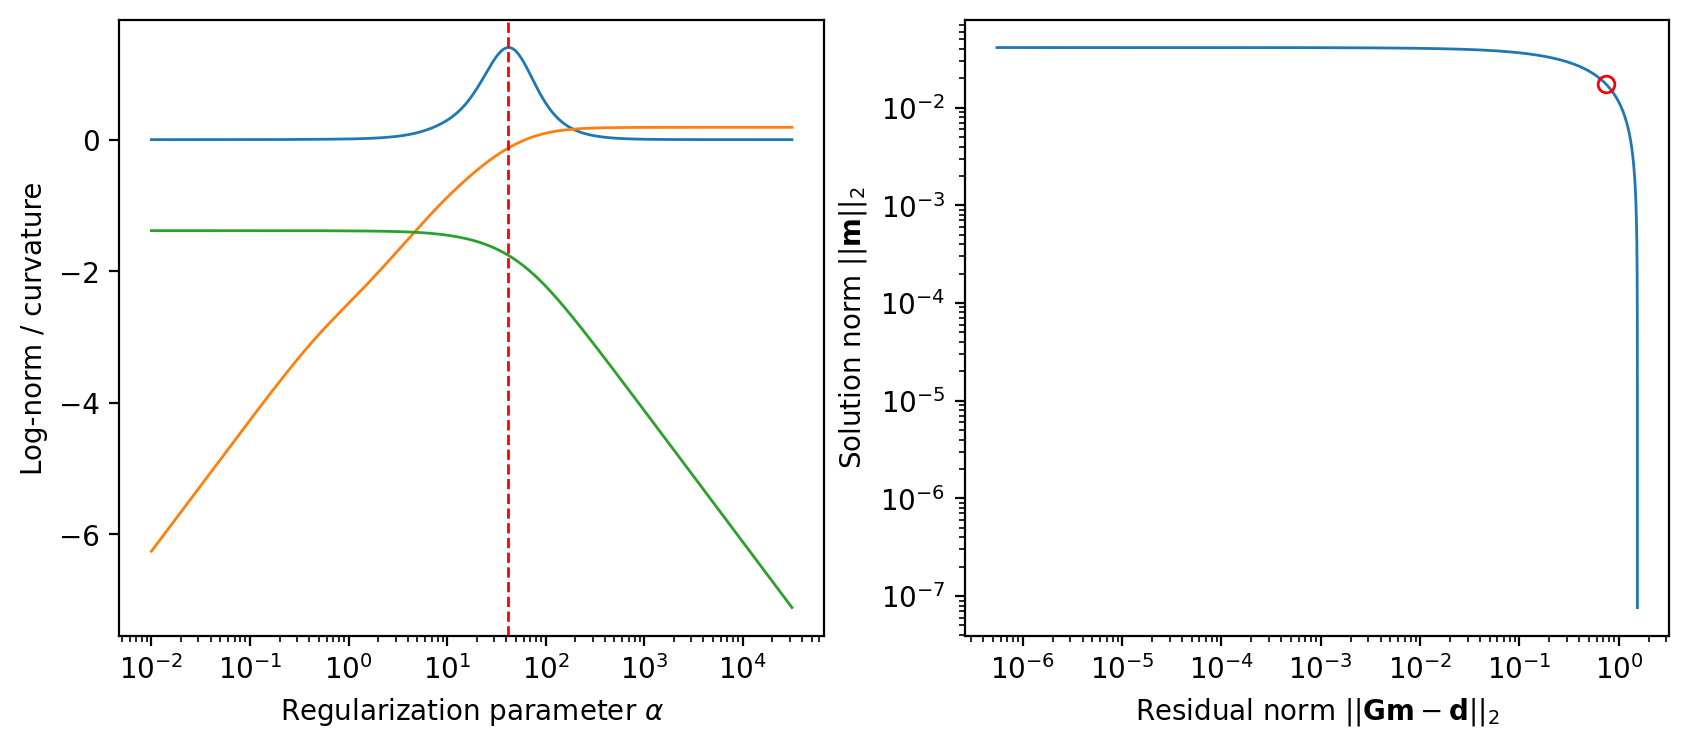

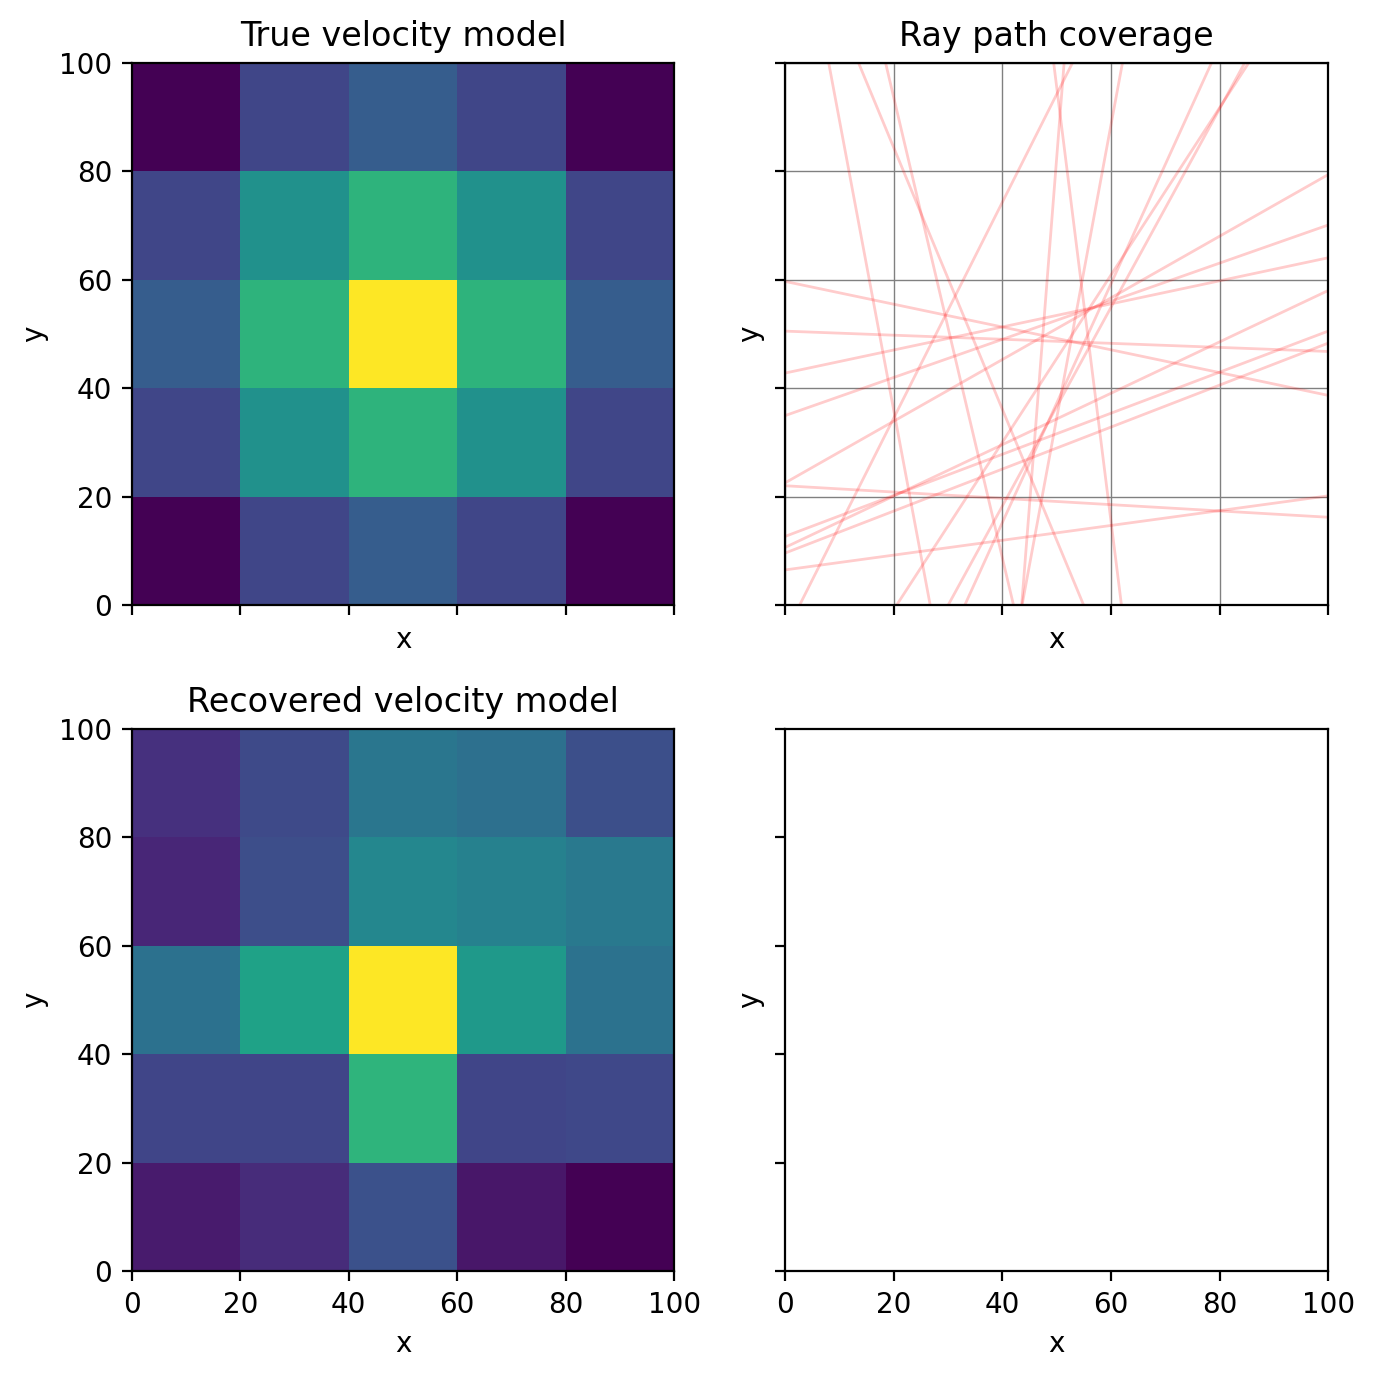

In [14]:
from scipy.sparse.linalg import lsqr
U, s, Vh = np.linalg.svd(G)

def GTR(d, G, alpha):
    ''' Generalized Tikhonov regularization solution '''
    return np.linalg.inv(G.T @ G + alpha**2 * np.eye(G.shape[1])) @ G.T @ d

alphas = np.logspace(-2, 4.5, 500)
alpha_models = []
for alpha in alphas:
    # alpha_models.append(zeroth_Tikhonov_regularization(dt, alpha))
    # alpha_models.append(damped_SVD(dt, alpha))
    # alpha_models.append(lsqr(G, dt, damp=alpha)[0])
    alpha_models.append(GTR(dt, G, alpha))
alpha_models = np.array(alpha_models)

## L-curve method
solution_norms = np.linalg.norm(alpha_models, axis=1)
residual_norms = np.linalg.norm((G @ alpha_models.T).T - dt, axis=1)

## Determine maximum curvature of the L-curve
log_sol_norms = np.log10(solution_norms)
log_res_norms = np.log10(residual_norms)

d_log_sol_norm_da = np.gradient(log_sol_norms, alphas)
d2_log_sol_norm_da2 = np.gradient(d_log_sol_norm_da, alphas)
d_log_res_norm_da = np.gradient(log_res_norms, alphas)
d2_log_res_norm_da2 = np.gradient(d_log_res_norm_da, alphas)

numerator = np.abs(d_log_res_norm_da * d2_log_sol_norm_da2 - d_log_sol_norm_da * d2_log_res_norm_da2)
denominator = (d_log_res_norm_da**2 + d_log_sol_norm_da**2)**1.5

curvatures = numerator / denominator
alpha_opt = alphas[np.argmax(curvatures)]
alpha_opt_idx = np.argmax(curvatures)

## Solution of the damped SVD method
# m = lsqr(G, dt, damp=alpha_opt)
# m_alpha = m[0]
m_alpha = GTR(dt, G, alpha_opt)
dv_v_alpha = m_alpha.reshape(xmesh.shape)

fig, ax = plt.subplots(1, 2)
ax[0].bar(range(m_true.size), m_true, width=1, alpha=0.5, label='True model')
ax[0].bar(range(m_true.size), m_alpha, width=1, alpha=0.5, label='Damped model')
ax[0].legend()
ax[0].set(xlabel='Model index', ylabel='Model value')
ax[1].scatter(G @ m_true, G @ m_alpha, label='Damped')
ax[1].scatter(G @ m_true, G @ m_L2, label='L2')
ax[1].set(xlabel='True data', ylabel='Predicted data')
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].semilogx(alphas, curvatures, lw=1, label='curvature')
ax[0].semilogx(alphas, log_res_norms, lw=1, label='$||\\mathbf{G}\\cdot\\mathbf{m}-\\mathbf{d}||$')
ax[0].semilogx(alphas, log_sol_norms, lw=1, label='$||\\mathbf{m}||$')
ax[0].set(xlabel='Regularization parameter $\\alpha$', ylabel='Log-norm / curvature')
ax[0].axvline(alpha_opt, color='r', lw=1, ls='--')
ax[1].loglog(residual_norms, solution_norms, lw=1)
ax[1].loglog(residual_norms[alpha_opt_idx], solution_norms[alpha_opt_idx], 'o', c='none', mec='r')
ax[1].set(xlabel='Residual norm $||\\mathbf{G}\\mathbf{m}-\\mathbf{d}||_2$', ylabel='Solution norm $||\\mathbf{m}||_2$')

plot_model(dv_v, dv_v_alpha, title=f'Damped SVD inversion (alpha={alpha_opt:.2f})')
plt.show()